In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
num_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_ds = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(train_loader)
batch_idx, (X, Y) = next(examples)
print(X.shape)
print(Y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.network = torch.nn.Sequential(*[
            torch.nn.Conv2d(1, 2, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(2, 4, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(4, 8, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(8, 16, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Flatten(-3, -1),
            torch.nn.Linear(16, 10)
        ])
    def forward(self, X):
        return self.network(X)
net = Network() 
print(X.shape, net(X).shape)

torch.Size([64, 1, 28, 28]) torch.Size([64, 10])


In [6]:
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=3e-4)


In [7]:
def calc_ds_stats(net, loader):
    losses = []
    accs = []
    for batch_idx, (X_batch, Y_batch) in enumerate(loader):
        Y_batch_pred = net(X_batch)
        loss = loss_function(Y_batch_pred, Y_batch)
        losses.append(loss.item())
        Y_batch_pred_idx = Y_batch_pred.argmax(dim=-1)
        acc = (Y_batch_pred_idx==Y_batch).sum().item()/len(Y_batch)
        accs.append(acc)
    return np.average(losses), np.average(accs)

In [8]:
calc_ds_stats(net, test_loader)

(2.3235191822052004, 0.08919999999999999)

In [9]:
losses = []
for epoch_idx in range(num_epochs):
    for batch_idx, (X_batch, Y_batch) in enumerate(train_loader):
        Y_batch_pred = net(X_batch)
        loss = loss_function(Y_batch_pred, Y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        
#     plt.plot(losses);plt.show() 
    print(calc_ds_stats(net, test_loader))


/home/akarshkumar0101/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


(0.4695525258779526, 0.8533)
(0.3244630485773087, 0.8981999999999999)
(0.24306363016366958, 0.9258)
(0.21554845720529556, 0.9338000000000001)
(0.19517443776130677, 0.9399)
(0.1822926327586174, 0.9408999999999998)
(0.17071643173694612, 0.9482999999999999)
(0.1580909326672554, 0.9503999999999999)
(0.15216126441955566, 0.9503)
(0.1416046880185604, 0.9541999999999999)


In [10]:
calc_ds_stats(net, test_loader)

(0.14160471186041831, 0.9541999999999999)

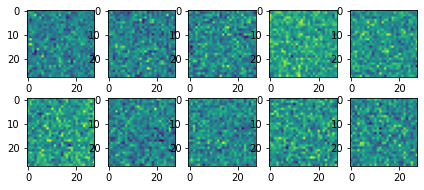

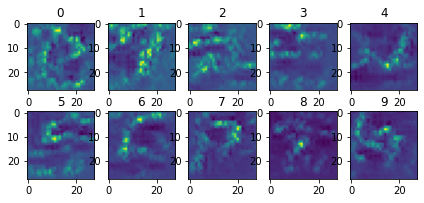

In [26]:

def experiment():
    torch.manual_seed(0)
    X = (torch.randn(10, 1, 28, 28)*.01).requires_grad_()
    Y = torch.arange(10)
    opt = torch.optim.SGD([X], lr=1e-1)
    
    plt.figure(figsize=(7,3))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(X[i, 0].detach().numpy())
        
        
    for i in range(10000):
        Y_pred = net(X)
        loss = loss_function(Y_pred, Y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    plt.figure(figsize=(7,3))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.title(f'{i}')
        plt.imshow(X[i, 0].detach().numpy())
    return X
X_exp = experiment() 

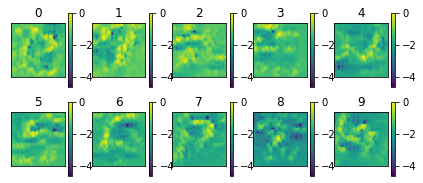

In [40]:
plt.figure(figsize=(7,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(f'{i}')
    plt.xticks([]), plt.yticks([])
    data = X_exp[i, 0].detach()
    data = (data-data.min())/(data.max()-data.min())
    data = (data+0.01).log()
    plt.imshow(data.numpy())
    plt.colorbar()


## We optimized over the input images in order for the network to output each of the ten categories of digits.
These images shown above show what types of images best activate a certain output for the network.
This was somewhat successful but the shapes are not entirely clear.